In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
class Data:
    @staticmethod
    def generate_linear(n=100):
        """ Data generation (Linear)

        Args:
            n (int):    the number of data points generated in total.

        Returns:
            data (np.ndarray, np.float):    the generated data with shape (n, 2). Each row represents
                a data point in 2d space.
            labels (np.ndarray, np.int):    the labels that correspond to the data with shape (n, 1).
                Each row represents a corresponding label (0 or 1).
        """
        data = np.random.uniform(0, 1, (n, 2))

        inputs = []
        labels = []

        for point in data:
            inputs.append([point[0], point[1]])

            if point[0] > point[1]:
                labels.append(0)
            else:
                labels.append(1)

        return np.array(inputs), np.array(labels).reshape((-1, 1))

    @staticmethod
    def generate_xor(n=100):
        """ Data generation (XOR)

        Args:
            n (int):    the number of data points generated in total.

        Returns:
            data (np.ndarray, np.float):    the generated data with shape (n, 2). Each row represents
                a data point in 2d space.
            labels (np.ndarray, np.int):    the labels that correspond to the data with shape (n, 1).
                Each row represents a corresponding label (0 or 1).
        """
        data_x = np.linspace(0, 1, n // 2)

        inputs = []
        labels = []

        for x in data_x:
            inputs.append([x, x])
            labels.append(0)

            if x == 1 - x:
                continue

            inputs.append([x, 1 - x])
            labels.append(1)

        return np.array(inputs), np.array(labels).reshape((-1, 1))
    @staticmethod
    def fetch_data(mode, n):
        #get data by mode 'Linear' or 'XOR', indicate which generator is used.
        
        assert mode == 'Linear' or mode == 'XOR' or mode == 'New'

        data_gen_func = {
            'Linear': Data.generate_linear,
            'XOR': Data.generate_xor
        }[mode]

        return data_gen_func(n)

In [3]:
class Layer :
    def __init__(self , input_size , output_size,learning_rate = 0.1 , optimizer ="default") :
        
        # init the weights by random
        self.weights = np.random.normal(0, 1, (input_size+1, output_size))
        self.m_t = np.zeros((input_size + 1, output_size))
        self.v_t = np.zeros((input_size + 1, output_size))
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.updatecount = 0
        self.momentum = np.zeros((input_size + 1, output_size))
    def forward (self , x, activation="sigmoid"):
        # compute the results of all inputs
        
        self.forward_gradient = np.append(x, np.ones((x.shape[0], 1)), axis=1)
        
        self.y = self.activation_function(np.matmul(self.forward_gradient, self.weights),activation)
        return self.y
    
    def backward(self, derivative, activation="sigmoid"):
        #  Calculate the back gradient by multiply gradient and weights
        
        self.backward_gradient = np.multiply(self.de_activation_function(self.y,activation), derivative)
        
        return np.matmul(self.backward_gradient,self.weights[:-1].T)
        
    def update(self):
        """
        update the weight
        default : by multiplication the learning rate
        """
        #calculates the gradient by multiplication output of the second hidden layer and backpropagated gradient
        self.gradient = np.matmul(self.forward_gradient.T,self.backward_gradient)
        
        if(self.optimizer  == 'adam'):
            self.updatecount+=1
            self.m_t = 0.9 * self.v_t + 0.1 *  self.gradient #updates the moving averages of the gradient
            self.v_t = 0.999 * self.v_t + 0.001 * self.gradient  * self.gradient  #updates the moving averages of the squared gradient
            m_cap = self.m_t / (1.0 - 0.9 ** self.updatecount) #calculates the bias-corrected estimates
            v_cap = self.v_t / (1.0 - 0.999 ** self.updatecount) #calculates the bias-corrected estimates
            delta_weight = -self.learning_rate * m_cap / (np.sqrt(v_cap) + 1e-8)
        elif self.optimizer == 'momentum':
            self.momentum = 0.9 * self.momentum - self.learning_rate * self.gradient
            delta_weight = self.momentum
        else :
            delta_weight = -(self.learning_rate*self.gradient)
        self.weights += delta_weight
        return self.gradient
    
    def activation_function(self,x,act):
        return {
        'sigmoid': lambda x: 1 / (1 + np.exp(-x)),    #calculate sigmoid function 
        'tanh': lambda x: np.tanh(x) ,                #calculate tanh function 
        'relu': lambda x: np.maximum(0.0, x),         #calculate relu function
        'no': lambda x: x ,                           #Without activation function
        }[act](x)
    def de_activation_function(self,x,act):
         return {
        'sigmoid': lambda x: np.multiply(x, 1.0 - x), #calculate the derivative of  sigmoid function 
        'tanh': lambda x: 1. - x ** 2,               #calculate the derivative of  tanh function 
        'relu': lambda x:  1. * (x > 0),              #calculate the derivative of  relu function
        'no': lambda x: 1.,    #Without activation function
         }[act](x)

In [4]:
class Model :
    def __init__(self,input_size, hidden_size, output_size, learning_rate, epochs,print_interval,activation = 'sigmoid',optimizer = 'default'):
        #defult  original parameters
        
        self.input_size = input_size
        self.hidden_size = hidden_size        # the number of hidden neurons used in this model.
        self.output_size=output_size 
        self.learning_rate=learning_rate         
        self.epochs=epochs                    # the total number of training steps.       
        self.print_interval=print_interval    # the number of steps between each reported number
        self.activation = activation          # the activation type to use
        self.layers = []
        self.activations = []
        
        self.epochArr,self.lossArr = [],[]
        
        size = [input_size, hidden_size , hidden_size, output_size]
        
        #init each layer
        for input_nn, output_nn in list(zip(size[:-1], size[1:])):
            self.layers += [Layer(input_size=input_nn, output_size=output_nn , learning_rate = self.learning_rate, optimizer = optimizer)]
            self.activations.append(self.activation)
        self.activations[-1] = 'sigmoid'
    def loss(self, y, y_hat):
        #MSE
        return np.mean((y - y_hat)**2)

    def derivative_loss(self, y, y_hat):
        # Differentiate with respect to N (total number of datasets)
        return (y - y_hat)*(2/y.shape[0])     
    def forward(self,inputs):
        """  forward pass.
        inputs and passing each layer through the network and return results
        """
        tmpinput = inputs
        for layer,act in  zip(self.layers ,self.activations ):
            tmpinput = layer.forward(tmpinput,act )
        return tmpinput
    
        
    def backward(self,outputs):
        """  backward pass.
        utilize the saved loss to compute gradients and update the network all the way to the input layer
        """
        tmpoutput = outputs
        for layer,act in  zip(self.layers[::-1],self.activations):
            tmpoutput = layer.backward(tmpoutput,act )
        
    def update(self):
        gradients = [[layer.update()] for layer in self.layers]
        return gradients
        
    def train(self , inputs , labels):
        """ The training routine that runs and update the model.

        Args:
            inputs: the training (and testing) data used in the model.
            labels: the ground truth of correspond to input data.
        """
        # make sure that the amount of data and label is match
        assert inputs.shape[0] == labels.shape[0]

        n = inputs.shape[0]
        time_started = time.time()
        """
         for idx in range(n):
                operation in each training step:
                  1. forward passing
                  2. compute loss
                  3. propagate gradient backward to the front
        """
       
        for epoch in range(self.epochs) :
            self.outputs = self.forward(inputs)
            loss_linear = self.loss(self.outputs, label) 
            self.backward(self.derivative_loss(self.outputs, label))
            self.update()  
            
            self.epochArr.append(epoch)
            self.lossArr.append(round(loss_linear, 4) )
            
#             if(epoch == 100000):
#                 self.learning_rate /= 100
            if epoch % self.print_interval == 0:
                print(f'Epoch {epoch} loss : {loss_linear:.4f}')
                self.test(inputs, labels)
        time_finished = time.time()
        total = time_finished - time_started
        print('Training finished')
        self.plot_loss()
        print('total time:{}'.format(total))
        self.test(inputs, labels)
        
                    
    def test(self, inputs, labels):
        """ The testing routine that run forward pass and report the accuracy.

        Args:
            inputs: the testing data. One or several data samples are both okay.
                The shape is expected to be [BatchSize, 2].
            labels: the ground truth correspond to the inputs.
        """
        n = inputs.shape[0]

        error = 0.0
        for idx in range(n):
            result = self.forward(inputs[idx:idx+1, :])
            error += abs(result - labels[idx:idx+1, :])

        error /= n
        print('accuracy: %.2f' % ((1 - error)*100) + '%')
        print('')
    @staticmethod
    def plot_result(data, gt_y, pred_y):
        """ Data visualization with ground truth and predicted data comparison. There are two plots
        for them and each of them use different colors to differentiate the data with different labels.

        Args:
            data:   the input data
            gt_y:   ground truth to the data
            pred_y: predicted results to the data
        """
        assert data.shape[0] == gt_y.shape[0]
        assert data.shape[0] == pred_y.shape[0]

        plt.figure()

        plt.subplot(1, 2, 1)
        plt.title('Ground Truth', fontsize=18)

        for idx in range(data.shape[0]):
            if gt_y[idx] == 0:
                plt.plot(data[idx][0], data[idx][1], 'ro')
            else:
                plt.plot(data[idx][0], data[idx][1], 'bo')

        plt.subplot(1, 2, 2)
        plt.title('Prediction', fontsize=18)

        for idx in range(data.shape[0]):
            if pred_y[idx] == 0:
                plt.plot(data[idx][0], data[idx][1], 'ro')
            else:
                plt.plot(data[idx][0], data[idx][1], 'bo')

        plt.show()
    def plot_loss(self):
        plt.figure()
        plt.title('Learning curve', fontsize=18)
        plt.plot(self.epochArr, self.lossArr)

        plt.show()

=== Linear ===
Epoch 0 loss : 0.2494
accuracy: 50.09%

Epoch 5000 loss : 0.2460
accuracy: 50.75%

Epoch 10000 loss : 0.0000
accuracy: 99.95%

Epoch 15000 loss : 0.0000
accuracy: 99.98%

Epoch 20000 loss : 0.0000
accuracy: 99.99%

Epoch 25000 loss : 0.0000
accuracy: 99.99%

Epoch 30000 loss : 0.0000
accuracy: 99.99%

Epoch 35000 loss : 0.0000
accuracy: 99.99%

Epoch 40000 loss : 0.0000
accuracy: 100.00%

Epoch 45000 loss : 0.0000
accuracy: 100.00%

Training finished


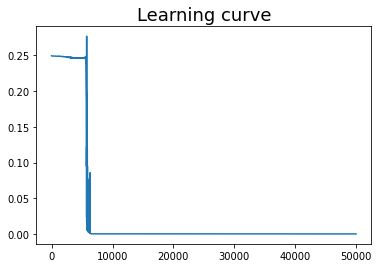

total time:13.347656726837158
accuracy: 100.00%

Linear predictions:
[[0.0000e+00]
 [0.0000e+00]
 [9.9995e-01]
 [0.0000e+00]
 [1.4000e-04]
 [0.0000e+00]
 [0.0000e+00]
 [9.9995e-01]
 [0.0000e+00]
 [9.9995e-01]
 [0.0000e+00]
 [0.0000e+00]
 [9.9995e-01]
 [0.0000e+00]
 [9.9995e-01]
 [9.9995e-01]
 [9.9995e-01]
 [0.0000e+00]
 [9.9995e-01]
 [0.0000e+00]
 [9.9995e-01]
 [9.9995e-01]
 [0.0000e+00]
 [9.9995e-01]
 [9.9995e-01]
 [9.9995e-01]
 [9.9995e-01]
 [4.0000e-05]
 [0.0000e+00]
 [0.0000e+00]
 [9.9995e-01]
 [9.9995e-01]
 [9.9995e-01]
 [9.9995e-01]
 [0.0000e+00]
 [9.9995e-01]
 [0.0000e+00]
 [9.9995e-01]
 [2.8000e-04]
 [0.0000e+00]
 [0.0000e+00]
 [0.0000e+00]
 [0.0000e+00]
 [0.0000e+00]
 [9.9995e-01]
 [9.9995e-01]
 [9.9995e-01]
 [9.9995e-01]
 [0.0000e+00]
 [0.0000e+00]
 [0.0000e+00]
 [9.9995e-01]
 [9.9995e-01]
 [0.0000e+00]
 [9.9995e-01]
 [0.0000e+00]
 [0.0000e+00]
 [0.0000e+00]
 [9.9995e-01]
 [0.0000e+00]
 [9.9995e-01]
 [9.9995e-01]
 [0.0000e+00]
 [0.0000e+00]
 [0.0000e+00]
 [0.0000e+00]
 [9.999

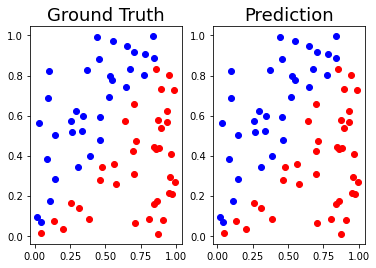

In [12]:
if __name__ == '__main__':
    input_size = 2
    hidden_size = 4
    output_size = 1
    learning_rate = 0.5
    epochs = 50000
    print_interval = 5000
    
    optimizer = "default"
    activation ="relu"
    print("=== Linear ===")
    data, label = Data.fetch_data('Linear', 70)
    model = Model(input_size, hidden_size, output_size, learning_rate, epochs,print_interval,activation,optimizer)
    model.train(data, label)
    
    pred_result = np.round(model.forward(data))
    print('Linear predictions:\n{}'.format(np.round(model.forward(data),5)))
    model.plot_result(data, label, pred_result)

=== XOR ===
Epoch 0 loss : 0.3164
accuracy: 49.83%

Epoch 5000 loss : 0.0000
accuracy: 99.89%

Epoch 10000 loss : 0.0000
accuracy: 99.96%

Epoch 15000 loss : 0.0000
accuracy: 99.98%

Epoch 20000 loss : 0.0000
accuracy: 99.99%

Epoch 25000 loss : 0.0000
accuracy: 99.99%

Epoch 30000 loss : 0.0000
accuracy: 99.99%

Epoch 35000 loss : 0.0000
accuracy: 99.99%

Epoch 40000 loss : 0.0000
accuracy: 99.99%

Epoch 45000 loss : 0.0000
accuracy: 99.99%

Training finished


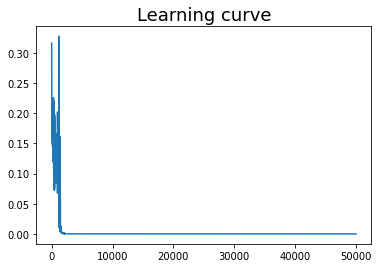

total time:13.504269123077393
accuracy: 100.00%

XOR predictions:
[[0.0000e+00]
 [1.0000e+00]
 [0.0000e+00]
 [1.0000e+00]
 [0.0000e+00]
 [1.0000e+00]
 [0.0000e+00]
 [1.0000e+00]
 [0.0000e+00]
 [1.0000e+00]
 [0.0000e+00]
 [1.0000e+00]
 [0.0000e+00]
 [1.0000e+00]
 [0.0000e+00]
 [1.0000e+00]
 [0.0000e+00]
 [1.0000e+00]
 [0.0000e+00]
 [1.0000e+00]
 [0.0000e+00]
 [1.0000e+00]
 [0.0000e+00]
 [1.0000e+00]
 [0.0000e+00]
 [1.0000e+00]
 [0.0000e+00]
 [1.0000e+00]
 [0.0000e+00]
 [1.0000e+00]
 [1.0000e-05]
 [1.0000e+00]
 [3.1000e-04]
 [9.9966e-01]
 [4.8000e-04]
 [1.3000e-04]
 [9.9933e-01]
 [4.0000e-05]
 [9.9991e-01]
 [1.0000e-05]
 [9.9991e-01]
 [0.0000e+00]
 [9.9991e-01]
 [0.0000e+00]
 [9.9991e-01]
 [0.0000e+00]
 [9.9991e-01]
 [0.0000e+00]
 [9.9991e-01]
 [0.0000e+00]
 [9.9991e-01]
 [0.0000e+00]
 [9.9991e-01]
 [0.0000e+00]
 [9.9991e-01]
 [0.0000e+00]
 [9.9991e-01]
 [0.0000e+00]
 [9.9991e-01]
 [0.0000e+00]
 [9.9991e-01]
 [0.0000e+00]
 [9.9991e-01]
 [0.0000e+00]
 [9.9991e-01]
 [0.0000e+00]
 [9.9991e-

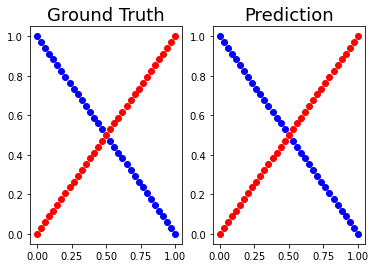

In [13]:
    print("=== XOR ===")
    data, label = Data.fetch_data('XOR', 70)
    model = Model(input_size, hidden_size, output_size, learning_rate, epochs,print_interval,activation,optimizer)
    model.train(data, label)
    # 訓練完模型 開始預測   
    pred_result = np.round(model.forward(data)) 
    print('XOR predictions:\n{}'.format(np.round(model.forward(data),5)))
    Model.plot_result(data, label, pred_result)